In [1]:
from lib.abstract_torch import get_device, get_loss, get_optimizer
from lib.dataloader import get_MNIST_loaders
from lib.models import ANN, LoRA_ANN
from lib.train import train_ANN
from lib.test import test
from lib.save import save

import os
import numpy as np
import torch

In [2]:
train_vanilla = False

In [3]:
device = get_device(0)

In [4]:
device

device(type='cuda', index=0)

In [5]:
path = os.path.dirname(os.path.abspath("__file__"))
data_path = path + "\\data"
model_path = path + "\\ANN_LoRA\\"

Playable HPs :
- LoRA rank
- trade-off

Other HPs :
- batch_size

In [6]:
# Data parameter
batch_size=128

# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10

# Train parameters
loss_name = "CE"
optimizer_name = "Adam"

## Reproducibility

In [7]:
random_seed = 88

## Get MNIST loaders

In [8]:
# We train on MNIST 0 to 4, then each new task is being able to classify a new digit (5 to 9)

In [9]:
train_loaders_list, val_loaders_list, test_loaders_list = get_MNIST_loaders(data_path, batch_size, random_seed, 0.8)

## Train vanilla ANN on digits 0 to 4

In [10]:
if train_vanilla :
    train_loader = train_loaders_list[0]
    test_loader = test_loaders_list[0]

In [11]:
if train_vanilla :
    lr = 1e-3
    num_epochs = 5

In [12]:
if train_vanilla :
    model = ANN(num_inputs, num_hidden, num_outputs, random_seed)

In [13]:
if train_vanilla :
    train_ANN(model, loss_name, optimizer_name, lr, train_loader, num_epochs, batch_size, device, random_seed)

100%|██████████| 5/5 [00:11<00:00,  2.39s/it]


In [14]:
if train_vanilla :
    test(model, test_loader, batch_size, device)

## Save vanilla ANN

In [15]:
if train_vanilla :
    vanilla_path = model_path+"ICL5_state_dict_digits_0_to_4.pth"

In [16]:
if train_vanilla :
    save(vanilla_path, model)

## CL on digits 5 to 9 with LoRA

### Greedy HPO

In [17]:
import optuna
from functools import partial
import matplotlib.pyplot as plt

/home/mathis/miniconda3/envs/.jax_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
def define_model(trial, model_path, params) :
    lora_rank = trial.suggest_int("lora_rank", 8, 40)
    alpha = trial.suggest_float("alpha", 0.5, 3)
    
    num_inputs, num_hidden, num_outputs, batch_size = params
    lora_ann_model = LoRA_ANN(lora_rank,
                              alpha, 
                              model_path, 
                              num_inputs, 
                              num_hidden, 
                              num_outputs,
                              batch_size,
                              random_seed)

    return lora_ann_model

def objective(task_number, model_path, params, device, trial) :
    # Define model
    lora_ann_model = define_model(trial, model_path, params).to(device)
    
    # Set HPs
    lr = trial.suggest_float("lr", 5e-5, 1e-3)
    num_epochs = trial.suggest_int("num_epochs", 1, 4)
    
    # Train
    batch_size = params[-1]
    
    train_loader = train_loaders_list[task_number+1]
    #val_loader = val_loaders[task_number]

    train_ANN(lora_ann_model, loss_name, optimizer_name, lr, train_loader, num_epochs, batch_size, device, random_seed)
    
    # Test
    test_accs = np.zeros(task_number+1)
    for j in range(task_number+1) :
        test_acc = test(lora_ann_model, test_loaders_list[j+1], batch_size, device)
        test_accs[j] = test_acc
    
    # Compute score
    mu, sigma = np.mean(test_accs), np.std(test_accs)
    score = mu - sigma
    
    return score

In [19]:
def retrain_and_save_with_best_HPs (best_trial, i, model_path) :
    lora_rank  = best_trial.params["lora_rank"]
    alpha = best_trial.params["alpha"]
    lr = best_trial.params["lr"]
    num_epochs = best_trial.params["num_epochs"]
    
    lora_ann_model = LoRA_ANN(lora_rank,
                              alpha, 
                              model_path, 
                              num_inputs, 
                              num_hidden, 
                              num_outputs,
                              batch_size,
                              random_seed).to(device)

    # Train
    train_loader = train_loaders_list[i+1]
    #val_loader = val_loaders[i]

    train_ANN(lora_ann_model, loss_name, optimizer_name, lr, train_loader, num_epochs, batch_size, device, random_seed)
    
    # Test
    test_accs = np.zeros(10)
    for j in range(10) :
        test_acc = test(lora_ann_model, test_loaders_list[j+1], batch_size, device)
        test_accs[j] = test_acc
    
    # Save model
    fc1_update = lora_ann_model.model.fc1.weight + alpha*torch.mm(lora_ann_model.l1_lora_A, lora_ann_model.l1_lora_B).T
    lora_ann_model.model.fc1.weight = torch.nn.Parameter(fc1_update)
    
    fc2_update = lora_ann_model.model.fc2.weight + alpha*torch.mm(lora_ann_model.l2_lora_A, lora_ann_model.l2_lora_B).T
    lora_ann_model.model.fc2.weight = torch.nn.Parameter(fc2_update)
    
    model_path = path + f"ICL5_state_dict_digit_{i}.pth"
    save(model_path, lora_ann_model.model)
    
    return test_accs

In [20]:
def call_greedy_HPO(n_trials) :
    # Compute scores of the model trained on the first task
    model_path = path + "\\ANN_LoRA\\ICL5_state_dict_digits_0_to_4.pth"

    lora_rank = 16 # The value of this parameters has no influence
    alpha = 1.8 # The value of this parameter has no influence

    lora_ann_model = LoRA_ANN(lora_rank,
                            alpha, 
                            model_path, 
                            num_inputs, 
                            num_hidden, 
                            num_outputs, 
                            batch_size,
                            random_seed).to(device)

    # Test the model trained on digits 0 to 4
    test_accs = np.zeros(10)
    for j in range(5) :
        test_acc = test(lora_ann_model, test_loaders_list[j+1], batch_size, device)
        test_accs[j] = test_acc
            
    # Initialize variable to store the best HPs and the scores
    best_params = []
    scores = [test_acc]
    test_accs_matrix = [test_accs]
    mean_test_accs_through_past_tasks = [test_acc]

    for i in range(5,10) :
        print(f"Learning Task {i+1}")
        # Perform HPO
        storage = optuna.storages.InMemoryStorage()
        study = optuna.create_study(storage=storage,
                                    study_name="The Search",
                                    sampler=optuna.samplers.TPESampler(seed=random_seed),
                                    direction = "maximize")
        
        params = num_inputs, num_hidden, num_outputs, batch_size
        partial_objective = partial(objective, i, model_path, params, device)
        study.optimize(partial_objective,
                    n_trials=n_trials,
                    timeout=3600)

        # Retrain and save a model with the best params
        best_trial = study.best_trial
        best_params.append(best_trial.params)
        test_accs = retrain_and_save_with_best_HPs(best_trial, i, model_path) 
        
        model_path = path + f"ICL5_state_dict_digit_{i}.pth"
        
        # Compute and store scores
        mu, sigma = np.mean(test_accs[:i+1]), np.std(test_accs[:i+1])
        score = mu - sigma
        
        scores.append(score)
        test_accs_matrix.append(test_accs)
        mean_test_accs_through_past_tasks.append(mu)
    
    return test_accs_matrix

In [21]:
n_trials_list = [4,8,16,32,64,128]

In [22]:
test_accs_matrix_list = []
for n_trials in n_trials_list :
    test_accs_matrix = call_greedy_HPO(n_trials)
    test_accs_matrix_list += [test_accs_matrix]

[I 2024-05-27 16:05:41,374] A new study created in memory with name: The Search


Learning Task 6


100%|██████████| 4/4 [00:01<00:00,  2.43it/s]
[I 2024-05-27 16:05:43,546] Trial 0 finished with value: -20.574278350357883 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: -20.574278350357883.
100%|██████████| 1/1 [00:00<00:00,  2.44it/s]
[I 2024-05-27 16:05:44,488] Trial 1 finished with value: -20.601132958329824 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: -20.574278350357883.
100%|██████████| 1/1 [00:00<00:00,  2.44it/s]
[I 2024-05-27 16:05:45,426] Trial 2 finished with value: -20.201208689366833 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: -20.201208689366833.
100%|██████████| 4/4 [00:01<00:00,  2.45it/s]
[I 2024-05-27 16:05:47,584] Trial 3 finished with value: -18.99237426283178 and parameters: {'lora_rank': 10

Learning Task 7


100%|██████████| 4/4 [00:01<00:00,  2.22it/s]
[I 2024-05-27 16:05:52,523] Trial 0 finished with value: -20.435947226195108 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: -20.435947226195108.
100%|██████████| 1/1 [00:00<00:00,  2.23it/s]
[I 2024-05-27 16:05:53,583] Trial 1 finished with value: -20.684600436387754 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: -20.435947226195108.
100%|██████████| 1/1 [00:00<00:00,  2.23it/s]
[I 2024-05-27 16:05:54,646] Trial 2 finished with value: -20.310077832572052 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: -20.310077832572052.
100%|██████████| 4/4 [00:01<00:00,  2.22it/s]
[I 2024-05-27 16:05:57,054] Trial 3 finished with value: -18.22588945719598 and parameters: {'lora_rank': 10

Learning Task 8


100%|██████████| 4/4 [00:01<00:00,  2.05it/s]
[I 2024-05-27 16:06:02,389] Trial 0 finished with value: -19.815655392210395 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: -19.815655392210395.
100%|██████████| 1/1 [00:00<00:00,  2.07it/s]
[I 2024-05-27 16:06:03,576] Trial 1 finished with value: -20.469104669959343 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: -19.815655392210395.
100%|██████████| 1/1 [00:00<00:00,  2.06it/s]
[I 2024-05-27 16:06:04,771] Trial 2 finished with value: -18.912155051245577 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: -18.912155051245577.
100%|██████████| 4/4 [00:01<00:00,  2.06it/s]
[I 2024-05-27 16:06:07,421] Trial 3 finished with value: -17.808377653753197 and parameters: {'lora_rank': 1

Learning Task 9


100%|██████████| 4/4 [00:01<00:00,  2.21it/s]
[I 2024-05-27 16:06:12,847] Trial 0 finished with value: -20.267714926846907 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: -20.267714926846907.
100%|██████████| 1/1 [00:00<00:00,  2.23it/s]
[I 2024-05-27 16:06:14,085] Trial 1 finished with value: -20.29911786974513 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: -20.267714926846907.
100%|██████████| 1/1 [00:00<00:00,  2.24it/s]
[I 2024-05-27 16:06:15,325] Trial 2 finished with value: -20.265623273276262 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: -20.265623273276262.
100%|██████████| 4/4 [00:01<00:00,  2.22it/s]
[I 2024-05-27 16:06:17,911] Trial 3 finished with value: -19.00855281936412 and parameters: {'lora_rank': 10,

Learning Task 10


100%|██████████| 4/4 [00:01<00:00,  2.17it/s]
[I 2024-05-27 16:06:23,322] Trial 0 finished with value: -19.682382759660378 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: -19.682382759660378.
100%|██████████| 1/1 [00:00<00:00,  2.16it/s]
[I 2024-05-27 16:06:24,665] Trial 1 finished with value: -19.77240032691102 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: -19.682382759660378.
100%|██████████| 1/1 [00:00<00:00,  2.16it/s]
[I 2024-05-27 16:06:26,010] Trial 2 finished with value: -19.448182032108026 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: -19.448182032108026.
100%|██████████| 4/4 [00:01<00:00,  2.17it/s]
[I 2024-05-27 16:06:28,727] Trial 3 finished with value: -19.10283035737681 and parameters: {'lora_rank': 10,

Learning Task 6


100%|██████████| 4/4 [00:01<00:00,  2.44it/s]
[I 2024-05-27 16:06:34,083] Trial 0 finished with value: -20.574278350357883 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: -20.574278350357883.
100%|██████████| 1/1 [00:00<00:00,  2.43it/s]
[I 2024-05-27 16:06:35,021] Trial 1 finished with value: -20.601132958329824 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: -20.574278350357883.
100%|██████████| 1/1 [00:00<00:00,  2.39it/s]
[I 2024-05-27 16:06:35,963] Trial 2 finished with value: -20.201208689366833 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: -20.201208689366833.
100%|██████████| 4/4 [00:01<00:00,  2.44it/s]
[I 2024-05-27 16:06:38,125] Trial 3 finished with value: -18.99237426283178 and parameters: {'lora_rank': 10

Learning Task 7


100%|██████████| 4/4 [00:01<00:00,  2.24it/s]
[I 2024-05-27 16:06:49,269] Trial 0 finished with value: -20.308949781887783 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: -20.308949781887783.
100%|██████████| 1/1 [00:00<00:00,  2.23it/s]
[I 2024-05-27 16:06:50,326] Trial 1 finished with value: -20.617666450250788 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: -20.308949781887783.
100%|██████████| 1/1 [00:00<00:00,  2.22it/s]
[I 2024-05-27 16:06:51,385] Trial 2 finished with value: -20.089277457551262 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: -20.089277457551262.
100%|██████████| 4/4 [00:01<00:00,  2.24it/s]
[I 2024-05-27 16:06:53,781] Trial 3 finished with value: -16.70470776910168 and parameters: {'lora_rank': 10

Learning Task 8


100%|██████████| 4/4 [00:01<00:00,  2.05it/s]
[I 2024-05-27 16:07:06,037] Trial 0 finished with value: -17.765841090694984 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: -17.765841090694984.
100%|██████████| 1/1 [00:00<00:00,  2.05it/s]
[I 2024-05-27 16:07:07,232] Trial 1 finished with value: -19.810558111952794 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: -17.765841090694984.
100%|██████████| 1/1 [00:00<00:00,  2.07it/s]
[I 2024-05-27 16:07:08,422] Trial 2 finished with value: -17.158322017660083 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: -17.158322017660083.
100%|██████████| 4/4 [00:01<00:00,  2.06it/s]
[I 2024-05-27 16:07:11,066] Trial 3 finished with value: -11.63179142214286 and parameters: {'lora_rank': 10

Learning Task 9


100%|██████████| 4/4 [00:01<00:00,  2.25it/s]
[I 2024-05-27 16:07:24,152] Trial 0 finished with value: -20.1657109448884 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: -20.1657109448884.
100%|██████████| 1/1 [00:00<00:00,  2.24it/s]
[I 2024-05-27 16:07:25,387] Trial 1 finished with value: -20.29911786974513 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: -20.1657109448884.
100%|██████████| 1/1 [00:00<00:00,  2.24it/s]
[I 2024-05-27 16:07:26,623] Trial 2 finished with value: -19.74823169645939 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: -19.74823169645939.
100%|██████████| 4/4 [00:01<00:00,  2.25it/s]
[I 2024-05-27 16:07:29,185] Trial 3 finished with value: -18.718466089485137 and parameters: {'lora_rank': 10, 'alpha

Learning Task 10


100%|██████████| 4/4 [00:01<00:00,  2.18it/s]
[I 2024-05-27 16:07:42,187] Trial 0 finished with value: -18.635125941029603 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: -18.635125941029603.
100%|██████████| 1/1 [00:00<00:00,  2.18it/s]
[I 2024-05-27 16:07:43,514] Trial 1 finished with value: -19.788576410232363 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: -18.635125941029603.
100%|██████████| 1/1 [00:00<00:00,  2.19it/s]
[I 2024-05-27 16:07:44,839] Trial 2 finished with value: -17.95909319277007 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: -17.95909319277007.
100%|██████████| 4/4 [00:01<00:00,  2.18it/s]
[I 2024-05-27 16:07:47,542] Trial 3 finished with value: -17.35289770224779 and parameters: {'lora_rank': 10, 

Learning Task 6


100%|██████████| 4/4 [00:01<00:00,  2.44it/s]
[I 2024-05-27 16:08:00,966] Trial 0 finished with value: -20.574278350357883 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: -20.574278350357883.
100%|██████████| 1/1 [00:00<00:00,  2.43it/s]
[I 2024-05-27 16:08:01,901] Trial 1 finished with value: -20.601132958329824 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: -20.574278350357883.
100%|██████████| 1/1 [00:00<00:00,  2.43it/s]
[I 2024-05-27 16:08:02,837] Trial 2 finished with value: -20.201208689366833 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: -20.201208689366833.
100%|██████████| 4/4 [00:01<00:00,  2.44it/s]
[I 2024-05-27 16:08:05,004] Trial 3 finished with value: -18.99237426283178 and parameters: {'lora_rank': 10

Learning Task 7


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]
[I 2024-05-27 16:08:29,094] Trial 0 finished with value: -18.615821767278163 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: -18.615821767278163.
100%|██████████| 1/1 [00:00<00:00,  2.24it/s]
[I 2024-05-27 16:08:30,147] Trial 1 finished with value: -20.595236815492047 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: -18.615821767278163.
100%|██████████| 1/1 [00:00<00:00,  2.20it/s]
[I 2024-05-27 16:08:31,209] Trial 2 finished with value: -19.801624824273972 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 0 with value: -18.615821767278163.
100%|██████████| 4/4 [00:01<00:00,  2.22it/s]
[I 2024-05-27 16:08:33,619] Trial 3 finished with value: -13.798636302273845 and parameters: {'lora_rank': 1

Learning Task 8


100%|██████████| 4/4 [00:01<00:00,  2.06it/s]
[I 2024-05-27 16:09:01,559] Trial 0 finished with value: -18.012698411763864 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: -18.012698411763864.
100%|██████████| 1/1 [00:00<00:00,  2.06it/s]
[I 2024-05-27 16:09:02,748] Trial 1 finished with value: -19.604300365421544 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: -18.012698411763864.
100%|██████████| 1/1 [00:00<00:00,  2.06it/s]
[I 2024-05-27 16:09:03,939] Trial 2 finished with value: -17.006010529334347 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: -17.006010529334347.
100%|██████████| 4/4 [00:01<00:00,  2.06it/s]
[I 2024-05-27 16:09:06,588] Trial 3 finished with value: -8.813105166883432 and parameters: {'lora_rank': 10

Learning Task 9


100%|██████████| 4/4 [00:01<00:00,  2.22it/s]
[I 2024-05-27 16:09:36,587] Trial 0 finished with value: -20.232370296774665 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: -20.232370296774665.
100%|██████████| 1/1 [00:00<00:00,  2.24it/s]
[I 2024-05-27 16:09:37,824] Trial 1 finished with value: -20.29911786974513 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: -20.232370296774665.
100%|██████████| 1/1 [00:00<00:00,  2.23it/s]
[I 2024-05-27 16:09:39,060] Trial 2 finished with value: -19.98368462338096 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: -19.98368462338096.
100%|██████████| 4/4 [00:01<00:00,  2.23it/s]
[I 2024-05-27 16:09:41,641] Trial 3 finished with value: -18.250736663250542 and parameters: {'lora_rank': 10, 

Learning Task 10


100%|██████████| 4/4 [00:01<00:00,  2.18it/s]
[I 2024-05-27 16:10:10,528] Trial 0 finished with value: -18.43905465516454 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: -18.43905465516454.
100%|██████████| 1/1 [00:00<00:00,  2.17it/s]
[I 2024-05-27 16:10:11,862] Trial 1 finished with value: -19.780628061970774 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: -18.43905465516454.
100%|██████████| 1/1 [00:00<00:00,  2.18it/s]
[I 2024-05-27 16:10:13,192] Trial 2 finished with value: -17.62150071411405 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: -17.62150071411405.
100%|██████████| 4/4 [00:01<00:00,  2.18it/s]
[I 2024-05-27 16:10:15,896] Trial 3 finished with value: -16.32438762359477 and parameters: {'lora_rank': 10, 'al

Learning Task 6


100%|██████████| 4/4 [00:01<00:00,  2.43it/s]
[I 2024-05-27 16:10:46,027] Trial 0 finished with value: -20.574278350357883 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: -20.574278350357883.
100%|██████████| 1/1 [00:00<00:00,  2.41it/s]
[I 2024-05-27 16:10:46,965] Trial 1 finished with value: -20.601132958329824 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: -20.574278350357883.
100%|██████████| 1/1 [00:00<00:00,  2.44it/s]
[I 2024-05-27 16:10:47,903] Trial 2 finished with value: -20.201208689366833 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: -20.201208689366833.
100%|██████████| 4/4 [00:01<00:00,  2.44it/s]
[I 2024-05-27 16:10:50,066] Trial 3 finished with value: -18.99237426283178 and parameters: {'lora_rank': 10

Learning Task 7


100%|██████████| 4/4 [00:01<00:00,  2.18it/s]
[I 2024-05-27 16:11:35,074] Trial 0 finished with value: -19.11991933366542 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: -19.11991933366542.
100%|██████████| 1/1 [00:00<00:00,  2.15it/s]
[I 2024-05-27 16:11:36,144] Trial 1 finished with value: -20.595236815492047 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: -19.11991933366542.
100%|██████████| 1/1 [00:00<00:00,  2.15it/s]
[I 2024-05-27 16:11:37,218] Trial 2 finished with value: -19.894018136937976 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 0 with value: -19.11991933366542.
100%|██████████| 4/4 [00:01<00:00,  2.17it/s]
[I 2024-05-27 16:11:39,670] Trial 3 finished with value: -16.091012544670146 and parameters: {'lora_rank': 10, '

Learning Task 8


100%|██████████| 4/4 [00:02<00:00,  1.99it/s]
[I 2024-05-27 16:12:32,780] Trial 0 finished with value: -18.091871746328778 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: -18.091871746328778.
100%|██████████| 1/1 [00:00<00:00,  2.00it/s]
[I 2024-05-27 16:12:33,986] Trial 1 finished with value: -18.85619064766172 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: -18.091871746328778.
100%|██████████| 1/1 [00:00<00:00,  2.00it/s]
[I 2024-05-27 16:12:35,192] Trial 2 finished with value: -16.519542001118793 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: -16.519542001118793.
100%|██████████| 4/4 [00:02<00:00,  1.99it/s]
[I 2024-05-27 16:12:37,900] Trial 3 finished with value: -9.654635904754763 and parameters: {'lora_rank': 10,

Learning Task 9


100%|██████████| 4/4 [00:01<00:00,  2.16it/s]
[I 2024-05-27 16:13:32,284] Trial 0 finished with value: -20.19896367331131 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: -20.19896367331131.
100%|██████████| 1/1 [00:00<00:00,  2.17it/s]
[I 2024-05-27 16:13:33,530] Trial 1 finished with value: -20.29911786974513 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: -20.19896367331131.
100%|██████████| 1/1 [00:00<00:00,  2.16it/s]
[I 2024-05-27 16:13:34,782] Trial 2 finished with value: -19.46370846426177 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: -19.46370846426177.
100%|██████████| 4/4 [00:01<00:00,  2.17it/s]
[I 2024-05-27 16:13:37,417] Trial 3 finished with value: -17.69955021658305 and parameters: {'lora_rank': 10, 'alp

Learning Task 10


100%|██████████| 4/4 [00:01<00:00,  2.10it/s]
[I 2024-05-27 16:14:41,269] Trial 0 finished with value: -17.883408375332372 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: -17.883408375332372.
100%|██████████| 1/1 [00:00<00:00,  2.10it/s]
[I 2024-05-27 16:14:42,617] Trial 1 finished with value: -19.856530990498804 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: -17.883408375332372.
100%|██████████| 1/1 [00:00<00:00,  2.11it/s]
[I 2024-05-27 16:14:43,965] Trial 2 finished with value: -18.570466367526894 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 0 with value: -17.883408375332372.
100%|██████████| 4/4 [00:01<00:00,  2.10it/s]
[I 2024-05-27 16:14:46,746] Trial 3 finished with value: -15.6984387748661 and parameters: {'lora_rank': 10,

Learning Task 6


100%|██████████| 4/4 [00:01<00:00,  2.44it/s]
[I 2024-05-27 16:15:53,696] Trial 0 finished with value: -20.574278350357883 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: -20.574278350357883.
100%|██████████| 1/1 [00:00<00:00,  2.45it/s]
[I 2024-05-27 16:15:54,630] Trial 1 finished with value: -20.601132958329824 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: -20.574278350357883.
100%|██████████| 1/1 [00:00<00:00,  2.43it/s]
[I 2024-05-27 16:15:55,573] Trial 2 finished with value: -20.201208689366833 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: -20.201208689366833.
100%|██████████| 4/4 [00:01<00:00,  2.44it/s]
[I 2024-05-27 16:15:57,734] Trial 3 finished with value: -18.99237426283178 and parameters: {'lora_rank': 10

Learning Task 7


100%|██████████| 4/4 [00:01<00:00,  2.21it/s]
[I 2024-05-27 16:17:17,648] Trial 0 finished with value: -19.11991933366542 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: -19.11991933366542.
100%|██████████| 1/1 [00:00<00:00,  2.23it/s]
[I 2024-05-27 16:17:18,704] Trial 1 finished with value: -20.595236815492047 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: -19.11991933366542.
100%|██████████| 1/1 [00:00<00:00,  2.23it/s]
[I 2024-05-27 16:17:19,762] Trial 2 finished with value: -19.894018136937976 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 0 with value: -19.11991933366542.
100%|██████████| 4/4 [00:01<00:00,  2.22it/s]
[I 2024-05-27 16:17:22,176] Trial 3 finished with value: -16.091012544670146 and parameters: {'lora_rank': 10, '

Learning Task 8


100%|██████████| 4/4 [00:01<00:00,  2.06it/s]
[I 2024-05-27 16:18:50,473] Trial 0 finished with value: -17.87538997840894 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: -17.87538997840894.
100%|██████████| 1/1 [00:00<00:00,  2.05it/s]
[I 2024-05-27 16:18:51,671] Trial 1 finished with value: -18.99217857095778 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: -17.87538997840894.
100%|██████████| 1/1 [00:00<00:00,  2.06it/s]
[I 2024-05-27 16:18:52,863] Trial 2 finished with value: -16.32571095927919 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: -16.32571095927919.
100%|██████████| 4/4 [00:01<00:00,  2.06it/s]
[I 2024-05-27 16:18:55,515] Trial 3 finished with value: -9.999111916394451 and parameters: {'lora_rank': 10, 'alp

Learning Task 9


100%|██████████| 4/4 [00:01<00:00,  2.22it/s]
[I 2024-05-27 16:20:30,529] Trial 0 finished with value: -20.215603821438858 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: -20.215603821438858.
100%|██████████| 1/1 [00:00<00:00,  2.22it/s]
[I 2024-05-27 16:20:31,775] Trial 1 finished with value: -20.29911786974513 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: -20.215603821438858.
100%|██████████| 1/1 [00:00<00:00,  2.23it/s]
[I 2024-05-27 16:20:33,017] Trial 2 finished with value: -19.58480601086282 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: -19.58480601086282.
100%|██████████| 4/4 [00:01<00:00,  2.23it/s]
[I 2024-05-27 16:20:35,612] Trial 3 finished with value: -18.42939120803648 and parameters: {'lora_rank': 10, '

Learning Task 10


100%|██████████| 4/4 [00:01<00:00,  2.19it/s]
[I 2024-05-27 16:22:14,310] Trial 0 finished with value: -18.11658864343807 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: -18.11658864343807.
100%|██████████| 1/1 [00:00<00:00,  2.18it/s]
[I 2024-05-27 16:22:15,646] Trial 1 finished with value: -19.905671439722944 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: -18.11658864343807.
100%|██████████| 1/1 [00:00<00:00,  2.18it/s]
[I 2024-05-27 16:22:16,978] Trial 2 finished with value: -18.395068468470637 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 0 with value: -18.11658864343807.
100%|██████████| 4/4 [00:01<00:00,  2.18it/s]
[I 2024-05-27 16:22:19,680] Trial 3 finished with value: -16.58272497934803 and parameters: {'lora_rank': 10, 'a

Learning Task 6


100%|██████████| 4/4 [00:01<00:00,  2.43it/s]
[I 2024-05-27 16:24:28,451] Trial 0 finished with value: -20.574278350357883 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: -20.574278350357883.
100%|██████████| 1/1 [00:00<00:00,  2.44it/s]
[I 2024-05-27 16:24:29,388] Trial 1 finished with value: -20.601132958329824 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: -20.574278350357883.
100%|██████████| 1/1 [00:00<00:00,  2.42it/s]
[I 2024-05-27 16:24:30,330] Trial 2 finished with value: -20.201208689366833 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: -20.201208689366833.
100%|██████████| 4/4 [00:01<00:00,  2.43it/s]
[I 2024-05-27 16:24:32,505] Trial 3 finished with value: -18.99237426283178 and parameters: {'lora_rank': 10

Learning Task 7


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]
[I 2024-05-27 16:26:59,307] Trial 0 finished with value: -19.11991933366542 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: -19.11991933366542.
100%|██████████| 1/1 [00:00<00:00,  2.23it/s]
[I 2024-05-27 16:27:00,369] Trial 1 finished with value: -20.595236815492047 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: -19.11991933366542.
100%|██████████| 1/1 [00:00<00:00,  2.21it/s]
[I 2024-05-27 16:27:01,440] Trial 2 finished with value: -19.894018136937976 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 0 with value: -19.11991933366542.
100%|██████████| 4/4 [00:01<00:00,  2.22it/s]
[I 2024-05-27 16:27:03,850] Trial 3 finished with value: -16.091012544670146 and parameters: {'lora_rank': 10, '

Learning Task 8


100%|██████████| 4/4 [00:01<00:00,  2.06it/s]
[I 2024-05-27 16:29:43,680] Trial 0 finished with value: -17.659783046469855 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: -17.659783046469855.
100%|██████████| 1/1 [00:00<00:00,  2.05it/s]
[I 2024-05-27 16:29:44,901] Trial 1 finished with value: -18.95157375533406 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: -17.659783046469855.
100%|██████████| 1/1 [00:00<00:00,  2.04it/s]
[I 2024-05-27 16:29:46,099] Trial 2 finished with value: -16.109649644073837 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: -16.109649644073837.
100%|██████████| 4/4 [00:01<00:00,  2.07it/s]
[I 2024-05-27 16:29:48,731] Trial 3 finished with value: -10.043741935700485 and parameters: {'lora_rank': 10

Learning Task 9


100%|██████████| 4/4 [00:01<00:00,  2.24it/s]
[I 2024-05-27 16:33:05,118] Trial 0 finished with value: -20.149274205232206 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: -20.149274205232206.
100%|██████████| 1/1 [00:00<00:00,  2.20it/s]
[I 2024-05-27 16:33:06,363] Trial 1 finished with value: -20.315856941624332 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: -20.149274205232206.
100%|██████████| 1/1 [00:00<00:00,  2.21it/s]
[I 2024-05-27 16:33:07,605] Trial 2 finished with value: -19.433040170727757 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: -19.433040170727757.
100%|██████████| 4/4 [00:01<00:00,  2.24it/s]
[I 2024-05-27 16:33:10,179] Trial 3 finished with value: -17.783635219774368 and parameters: {'lora_rank': 1

Learning Task 10


100%|██████████| 4/4 [00:01<00:00,  2.17it/s]
[I 2024-05-27 16:36:21,134] Trial 0 finished with value: -18.155799939798293 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: -18.155799939798293.
100%|██████████| 1/1 [00:00<00:00,  2.14it/s]
[I 2024-05-27 16:36:22,477] Trial 1 finished with value: -19.858543382649728 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: -18.155799939798293.
100%|██████████| 1/1 [00:00<00:00,  2.17it/s]
[I 2024-05-27 16:36:23,822] Trial 2 finished with value: -18.384607547787287 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 0 with value: -18.155799939798293.
100%|██████████| 4/4 [00:01<00:00,  2.16it/s]
[I 2024-05-27 16:36:26,557] Trial 3 finished with value: -16.12444054354389 and parameters: {'lora_rank': 10

In [23]:
def visualize_greedy_HPO_matrix(test_accs_matrix, n_trials, savefig=False):
    plt.imshow(test_accs_matrix, cmap='viridis', interpolation='nearest')
    plt.yticks(np.arange(6), np.arange(4, 10))
    plt.xlabel("Accuracy on digit j...")
    plt.ylabel("...after training on digit i")
    plt.title(f"Result of greedy HPO with {n_trials} trials per task")
    plt.colorbar()
    if savefig :
        plt.savefig(f"results/ICL5_{n_trials}_trial_greedy_HPO_matrix_LoRA.png")
    plt.show()

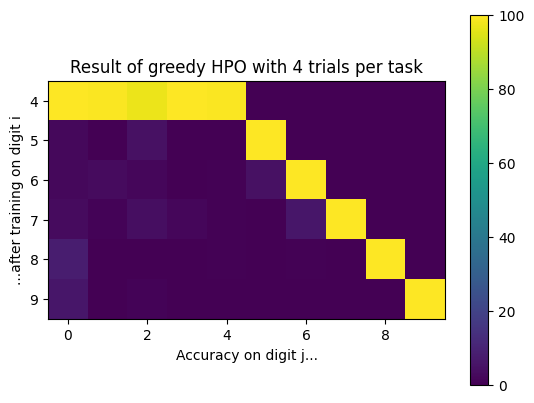

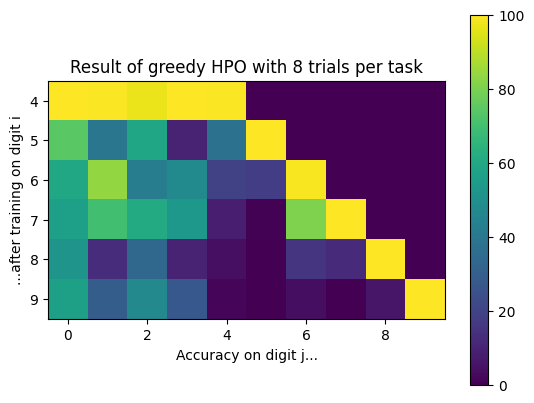

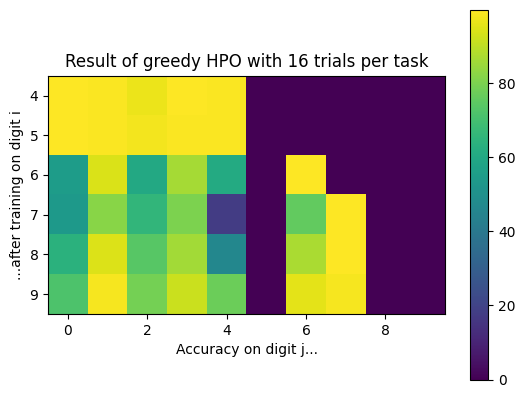

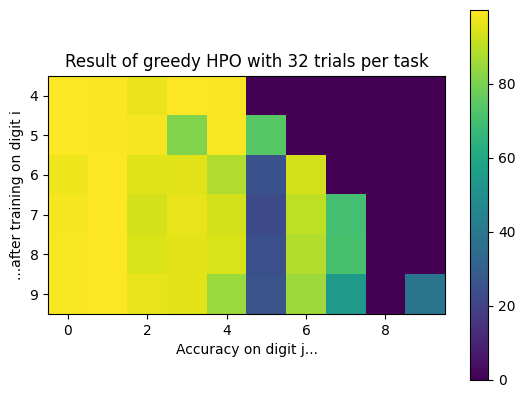

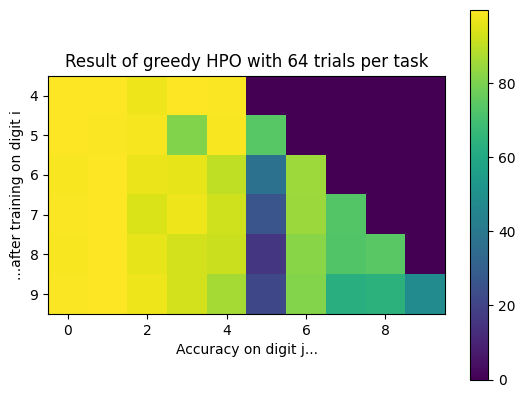

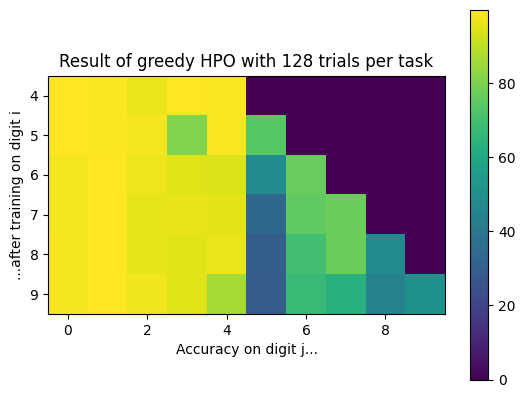

In [24]:
for test_accs_matrix, n_trials in zip(test_accs_matrix_list, n_trials_list) :
    visualize_greedy_HPO_matrix(test_accs_matrix, n_trials, savefig=True)

In [25]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [26]:
import matplotlib.pyplot as plt
import numpy as np


def visualize_greedy_HPO_curve(test_accs_matrix_list, n_trials_list, savefig=False):
    # Normalize n_trials values for the colormap
    norm = mcolors.LogNorm(vmin=min(n_trials_list), vmax=max(n_trials_list))
    colormap = cm.viridis

    fig, ax = plt.subplots(figsize=(10, 6))
    for test_accs_matrix, n_trials in zip(test_accs_matrix_list, n_trials_list):
        mean_accs = np.array(test_accs_matrix).sum(1) / np.arange(5, 11, 1)
        color = colormap(norm(n_trials))
        ax.plot(range(4,10), mean_accs, label=f"{n_trials} trials", color=color)
    
    ax.set_xlabel("Number of classes trained")
    ax.set_ylabel("Average accuracy for classes trained so far")
    ax.set_ylim(0, 100)
    ax.set_title("Result of greedy HPO with various numbers of trials")

    # Create a scalar mappable for the color bar
    sm = cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Number of Trials')

    ax.legend(loc='lower left')
    
    if savefig:
        plt.savefig(f"results/ICL5_greedy_HPO_curve_LoRA.png")
    
    plt.show()

# Example usage
# visualize_greedy_HPO_curve(test_accs_matrix_list, n_trials_list, savefig=True)


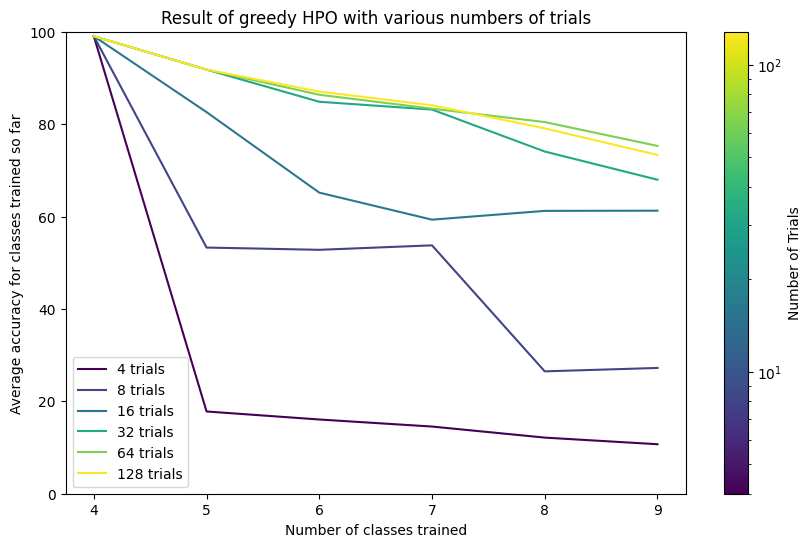

In [27]:
visualize_greedy_HPO_curve(test_accs_matrix_list, n_trials_list, savefig=True)

### Leaky HPO